## Model evaluation

In [1]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Statistics
using Unicode

In [2]:
using Revise
using TokenizersLite
using TransformersLite

In [3]:
includet("reporting.jl")
includet("training.jl")
includet("SentenceClassifier.jl")

## Load data

raw

In [4]:
path = "path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [5]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [6]:
nrow(df)

200000

transformed

In [7]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [8]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


## Tokenizers

In [9]:
vocab_directory = "..\\vocab\\bpe"
path_rules = joinpath(vocab_directory, "amazon_reviews_train_en_rules.txt")
path_vocab = joinpath(vocab_directory, "amazon_reviews_train_en_vocab.txt")
vocab = load_vocab(path_vocab)

sentence_splitter = RuleBasedSentenceSplitter()
tokenizer = load_bpe(path_rules, startsym="⋅")
#@show tokenizer = load_affix_tokenizer(path_vocab)
indexer = IndexTokenizer(vocab, "[UNK]")

display(sentence_splitter)
display(tokenizer)
display(indexer)

RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z", "C", "P", "Jul", "Eg", "Dec", "Sen", "Rev", "Mar", "BComm"  …  "E", "I", "J", "Snr", "eg", "Fri", "R", "Ms", "MBA", "Nov"]), non_breaking_numeric_prefixes=Set(["nr", "No", "pg", "Nr", "no", "p"]))

BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])

IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])

In [10]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end;

function preprocess(document, tokenizer; 
    pattern = r"[A-Za-z][A-Za-z]+\b", 
    max_length::Union{Nothing, Int}=nothing
    )
    tokens_all = Vector{String}[]
    for sentence in document
        sentence = clean(sentence)
        words = map(m->string(m.match), eachmatch(pattern, sentence))
        tokens = tokenizer(words)
        if !isnothing(max_length)
            if length(tokens) > max_length
                tokens = tokens[1:max_length]
            end
        end
        push!(tokens_all, tokens)
    end
    tokens_all
end;

function pad!(v::Vector{String}, sym::String, max_length::Int)
    if length(v) < max_length
        padding = [sym for i in 1:(max_length - length(v))]
        append!(v, padding)
    end
end;

In [11]:
max_length = 30;

In [12]:
@time documents_split = [sentence_splitter(d) for d in documents];
@time documents_test_split = [sentence_splitter(d) for d in documents_test];

 12.181070 seconds (90.58 M allocations: 5.235 GiB, 11.84% gc time, 1.20% compilation time)
  0.331522 seconds (2.30 M allocations: 134.435 MiB, 10.95% gc time, 15.05% compilation time)


In [13]:
@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents_split)
# hack to make sure all the indices have the same number of rows:
for i in 1:length(tokens)
    pad!(tokens[i][1], tokenizer.unksym, max_length)
end
@time indices = map(t->indexer(t), tokens) 

y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3

X_train, y_train = indices[idxs], y_train[idxs];
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 49.888224 seconds (659.24 M allocations: 20.706 GiB, 8.24% gc time, 1.23% compilation time)
 26.819460 seconds (642.99 k allocations: 180.546 MiB, 0.57% compilation time)
train samples:      (144000,) (144000,)
validation samples: (16000,) (16000,)


In [14]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3


@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test_split)
for i in 1:length(tokens)
    pad!(tokens[i][1], tokenizer.unksym, max_length)
end
@time indices_test = map(t->indexer(t), tokens) 
X_test, y_test = indices_test[idxs], y_test[idxs]

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.721635 seconds (6.10 M allocations: 213.282 MiB, 10.11% compilation time)
  0.690950 seconds (65.23 k allocations: 7.153 MiB, 9.78% compilation time)
test indices: (5000,)
test samples: (4000,) (4000,)


In [15]:
train_data_loader = DataLoader(train_data; batchsize=32, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=32, shuffle=false);

## Evaluate

In [16]:
loss(x, y) = Flux.binarycrossentropy(model(x), y);
loss(x::Tuple) = loss(x[1], x[2]);
accuracy(ŷ, y) = mean((ŷ .> 0.5) .== y);

In [17]:
directory = "../outputs/20220714_1548"

BSON.@load joinpath(directory, "model.bson") model
model

SentenceClassifer(base_model=TransformersLite.TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{Matrix{Float32}}, Dropout{Float64, Colon, TaskLocalRNG}, Vector{TransformerEncoderBlock}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, FlattenLayer, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}(Embed((32, 7455)), PositionEncoding(32), Dropout(0.1), TransformerEncoderBlock[TransformerEncoderBlock(MultiheadAttention(num_heads=4, head_size=8, 32=>32), LayerNorm(32), Dense(32 => 128, relu), Dense(128 => 32), LayerNorm(32))], Dense(32 => 1), FlattenLayer(), Dense(30 => 1)), activation=σ, aggregate=parabolic_weighted_average)

In [18]:
@time batched_metric(accuracy, train_data_loader, g=model)

120.118553 seconds (60.54 M allocations: 68.988 GiB, 10.61% gc time, 11.71% compilation time)


0.9145902777777778

In [19]:
@time batched_metric(accuracy, val_data_loader, g=model)

 13.791423 seconds (2.56 M allocations: 7.492 GiB, 13.41% gc time)


0.8950625

In [20]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[0.426853, 0.372681, 0.340652, 0.31623, 0.28017, 0.269331,…
  "train_acc"  => Any[0.8125, 0.84375, 0.859375, 0.867188, 0.875, 0.875, 0.8984…
  "val_acc"    => Any[0.875, 0.882812, 0.90625, 0.90625, 0.914062, 0.914062, 0.…
  "val_loss"   => Any[0.364587, 0.291639, 0.281952, 0.266503, 0.253653, 0.26324…

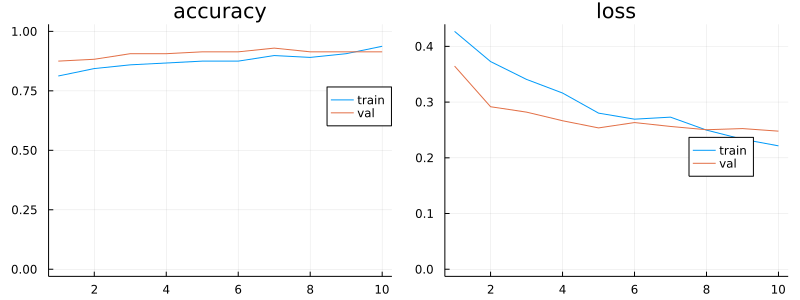

In [21]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))
plot(p1, p2, layout=grid(1, 2), size=(800, 300))

## Test data

In [22]:
probs = model(X_test)
accuracy(probs, y_test)

0.8925

In [23]:
y_pred = Int.(probs .> 0.5);

In [24]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1798   202
  228  1772

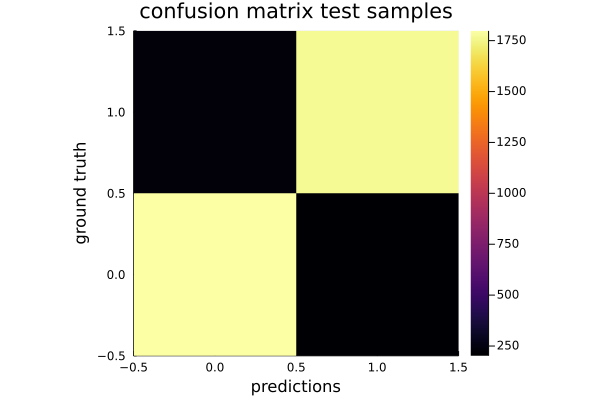

In [25]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
#savefig(p, "../outputs/confusion_matrix_regression.png")
p

In [26]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.89    0.90      0.89     2000
           1       0.90    0.89      0.89     2000

weighted avg       0.89    0.89      0.89     4000

In [27]:
nshow = 3

for label in [0, 1]
    println("\ntrue label = $label")
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 1))[vec(idxs)]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    println("#incorrect $(length(idxs_wrong))")
    println(" idx  y  ŷ    prob  ")
    for idx in sample(idxs_wrong, nshow, replace=false)
        @printf("%4d  %d  %d  %.4f\n",
            idx, y_test[idx], y_pred[idx], probs[idx], 
        )
        sentences = documents_test_split[labels_test.!==3][idx]
        y = predict_probs(model, X_test[idx])
        for (p, s) in zip(y, sentences)
            @printf("\t    %.4f %s\n", p, s)
        end
        println("")
    end
end


true label = 0
#incorrect 202
 idx  y  ŷ    prob  
1227  0  1  0.7785
	    0.7785 These are a good value for your money they look nice but they are way too heavy I saw some review that said lightweight which made me purchase ....they are definitely not lightweight

1550  0  1  0.8050
	    0.8050 Looks like circus tent material, but it fits well on the bed and looks a bit better than nothing if you want to hide stuff you keep under your bed.

1431  0  1  0.6195
	    0.4702 We didn't expect the light to change colors, but it made for a fun joke with friends.
	    0.9848 The light it very bright and attracts plenty of attention at dark.
	    0.0955 However the first light only lasted one month, almost exactly.


true label = 1
#incorrect 228
 idx  y  ŷ    prob  
3993  1  0  0.0814
	    0.0804 So far everything is working.

2973  1  0  0.1857
	    0.1857 Besides running small, the arms have no warm lining, and the strings came frayed.

2868  1  0  0.2880
	    0.2880 The accuracy is way of

## Only multiple sentences

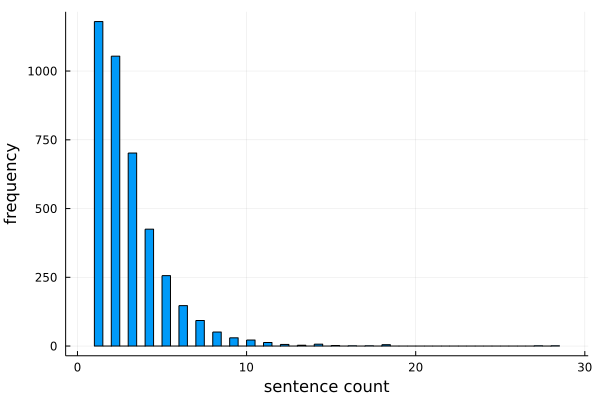

In [28]:
sentence_counts = length.(documents_test_split[labels_test .!= 3])

histogram(sentence_counts, xlabel="sentence count", ylabel="frequency", label="")

In [29]:
idxs = sentence_counts .> 2;
count(idxs)

1766

In [30]:
accuracy(probs[idxs], y_test[idxs])

0.9003397508493771

In [31]:
cm = confusion_matrix(vec(y_pred[idxs]), vec(y_test[idxs]), 0:1)

2×2 Matrix{Int64}:
 801   86
  90  789

In [32]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.90    0.90      0.90      887
           1       0.90    0.90      0.90      879

weighted avg       0.90    0.90      0.90     1766

## Probabilities for all labels

In [33]:
probs_all = model(indices_test);
y_pred_all = Int.(probs_all .> 0.5);

In [34]:
pos_max = argmax(probs_all)
pos_min = argmin(probs_all)

println(" idx  y  ŷ    prob  ")
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_max, labels_test[pos_max], y_pred_all[pos_max], probs_all[pos_max], documents_test[pos_max]
)
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_min, labels_test[pos_min], y_pred_all[pos_min], probs_all[pos_min], documents_test[pos_min]
)

 idx  y  ŷ    prob  
4692  5  1  1.0000  Great quality , works perfect
 918  1  0  0.0001  cheap and waste of money


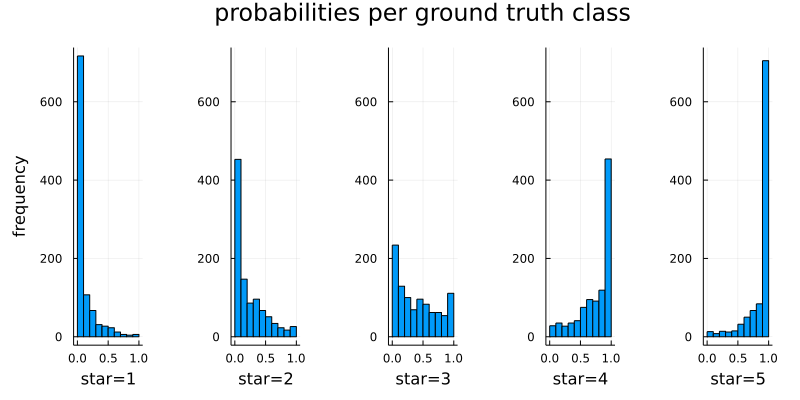

In [35]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
#savefig(p, "../outputs/probabilities_ground_truth.png")
p

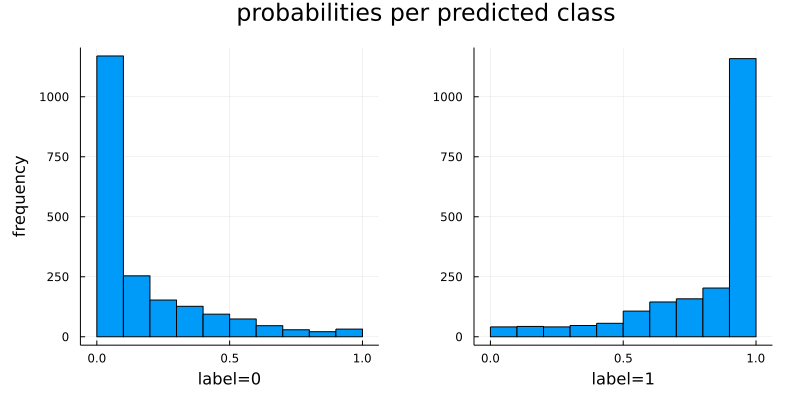

In [36]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per predicted class",
    margin=5Plots.mm)
#savefig(p, "../outputs/probabilities_ground_truth.png")
p

In [37]:
nshow = 3

label = 5
println("true label = $label")
idxs = labels_test .== label
idxs_label = (1:length(labels_test))[vec(idxs)]
idxs_wrong = idxs_label[probs_all[idxs] .<= 0.2]
println("#incorrect $(length(idxs_wrong))")
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_wrong, nshow, replace=false)
    @printf("%4d  %d  %d  %.4f  %s\n",
    idx, labels_test[idx], y_pred_all[idx], probs_all[idx], documents_test[idx]
    )
end

println("")

label = 1
println("true label = $label")
idxs = labels_test .== label
idxs_label = (1:length(labels_test))[vec(idxs)]
idxs_wrong = idxs_label[probs_all[idxs] .>= 0.8]
println("#incorrect $(length(idxs_wrong))")
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_wrong, nshow, replace=false)
    @printf("%4d  %d  %d  %.4f  %s\n",
    idx, labels_test[idx], y_pred_all[idx], probs_all[idx], documents_test[idx]
    )
end

true label = 5
#incorrect 21
 idx  y  ŷ    prob  
4641  5  0  0.0784  I think I would do it different if I ever have to it again. When trial fitting them I would mark the end of the first rail with a pencil, that way you won't put on loose or stretch them. Once stuck you cannot undo it.
4667  5  0  0.0131  They are ok except. The fitted pops off.
4915  5  0  0.1561  Mouse ON/OFF button location could be located somewhere more feasible.

true label = 1
#incorrect 10
 idx  y  ŷ    prob  
 291  1  1  0.8818  This would be an awesome blender if the lid were made worth a dang. It's a high enough powered little blender but the lid is so cheaply made that I literally have to keep a hand towel near by to hold the lid on with and it still gets saturated. The first time we used it my 3 year old wanted to help and ended up having hot coffee sprayed all over his hands and arms.
 837  1  1  0.9250  This product is great when it works, which is RARELY. We have attempted to record multiple soccer gam

## Single samples

In [38]:
idx = 4000  

text = documents_test[idx]

println(labels_test[idx])
println(text)
println("")

sentences = sentence_splitter(text)
tokens = preprocess(sentences, tokenizer, max_length=max_length)
for t in tokens
    println(join(t, "|"))
end
pad!(tokens[1], tokenizer.unksym, max_length)
x = indexer(tokens);

4
Easy setup with bluetooth to your phone, and clear instructions provided. This is my second time buying this product, my first one had the USB cable snap off at the Y with almost a year of constant use, could have been my fault due to heavy use. Only complaint is that it is slightly quieter than max volume with a regular aux cord.

⋅easy|⋅setup|⋅with|⋅bluetooth|⋅to|⋅your|⋅phone|⋅and|⋅clear|⋅instructions|⋅provided
⋅this|⋅is|⋅my|⋅second|⋅time|⋅buying|⋅this|⋅product|⋅my|⋅first|⋅one|⋅had|⋅the|⋅usb|⋅cable|⋅snap|⋅off|⋅at|⋅the|⋅with|⋅almost|⋅year|⋅of|⋅constant|⋅use|⋅could|⋅have|⋅been|⋅my|⋅fault
⋅only|⋅complaint|⋅is|⋅that|⋅it|⋅is|⋅slightly|⋅quieter|⋅than|⋅max|⋅volume|⋅with|⋅regular|⋅aux|⋅cord


In [39]:
y = predict_probs(model, x)
@printf "mean: %.4f ; weighted mean: %.4f\n" mean(y) parabolic_weighted_average(y)
for (p, s) in zip(y, sentences)
    @printf("%.4f %s\n", p, s)
end

mean: 0.7182 ; weighted mean: 0.8390
0.9971 Easy setup with bluetooth to your phone, and clear instructions provided.
0.1608 This is my second time buying this product, my first one had the USB cable snap off at the Y with almost a year of constant use, could have been my fault due to heavy use.
0.9968 Only complaint is that it is slightly quieter than max volume with a regular aux cord.
